In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
import warnings

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

Text(0, 0.5, 'y')

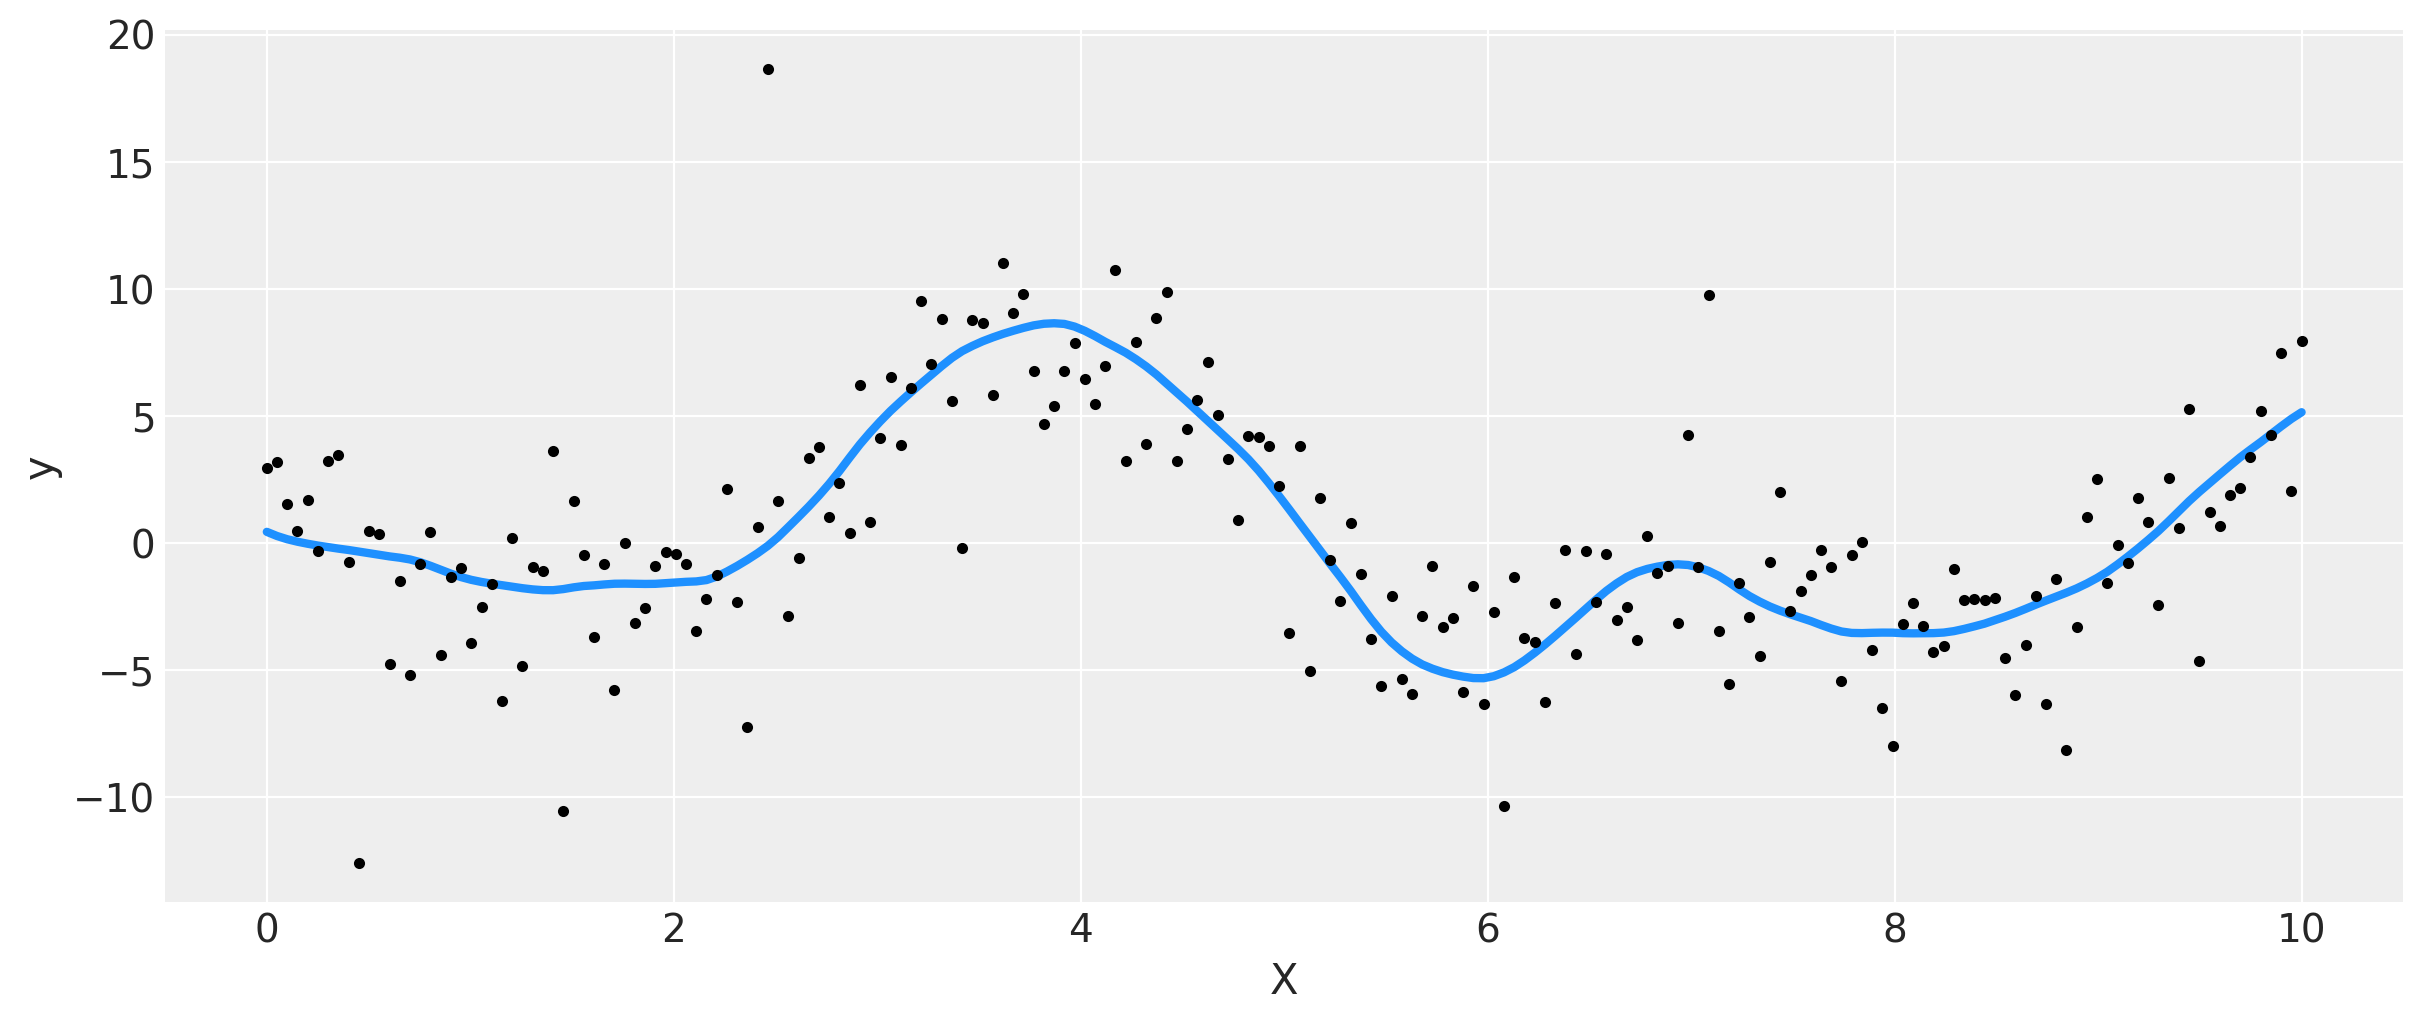

In [4]:
n = 200  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")

In [5]:
#Unconstraint
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.Normal(("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(500, chains=1, cores=1, tune = 500, return_inferencedata=True)

SyntaxError: invalid syntax (<ipython-input-5-e6a66ae8a69a>, line 13)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
#constraint
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)
    trace = pm.sample(500, chains=1, cores=1, tune = 500, return_inferencedata=True)

In [ ]:
fig = pm.traceplot(trace)

In [ ]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred0", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, var_names=['f_pred0'])

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred0"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend();